### Purpose of this script
- create monthly means of AVHRR LAI monsum_YYYY.nc files over the SW U.S. and save these means as .csv data
- Save the spatial mask used to create these mean values in the data native grid and the CMIP5 common grid
- show enough figures to prove this was done correctly and that the masked regions work for all indended grids. 

In [111]:
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pylab as plt
from netCDF4 import Dataset
from shapely.geometry import Polygon, Point
import geopandas as geo
import pandas as pd

These are the SW borders used for showing the area around the monitors in the four corners states
- In this work, I want to give these areas a bit of an extra buffer, as the course CMIP5 models will be getting data from an extent beyond these coordinates, and I want the more precice satellite data to be data from a similar area. 
- This can be accomplished by adding a bugger around these coordinates that are equal to the width and height of NETcdf data that will be used to represent the CMIP5 LAI estimates. 
    - dx common grid = 2.5
    - dy common grid = 2. 

In [89]:
lon_range = (-115., -102) # ~SW US
lat_range = (30., 42)     # ~ SW US

In [85]:
usa = geo.read_file('../Data/GIS/cb_2017_us_state_500k') # read in US shapefile 

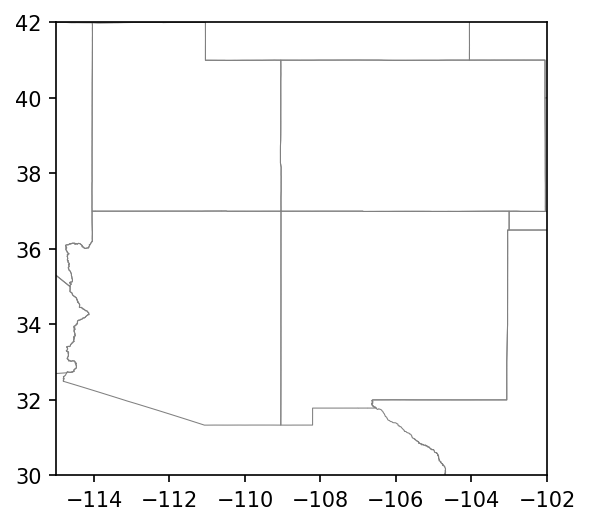

In [91]:
plt.figure(dpi=150)
ax1 = plt.subplot(111)
usa.plot(ax=ax1, facecolor='none', edgecolor="gray", linewidth=0.5)
ax1.set_xlim(lon_range)
ax1.set_ylim(lat_range)
plt.show()

In [56]:
lai_monthly_dir = os.path.join("..", "..", "metSpreadData", "AVHRR", "monthly_mean_files")
os.listdir(lai_monthly_dir)[:4]

['.DS_Store', 'monmeans_1983.nc', 'monmeans_1984.nc', 'monmeans_1985.nc']

In [150]:
nc = Dataset(os.path.join(lai_monthly_dir, "monmeans_1990.nc"),"r" )

In [151]:
Z = nc.variables['LAI'][0,:,:]

In [152]:
Z.shape

(3600, 7200)

In [153]:
type(Z)

numpy.ma.core.MaskedArray

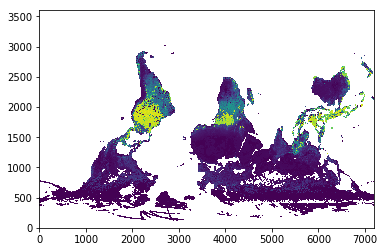

In [59]:
plt.pcolor(Z)

### Get the coordinates of the LAI nc data 

In [154]:
lat = nc.variables['latitude'][:]
lon = nc.variables['longitude'][:]

<function matplotlib.pyplot.show(*args, **kw)>

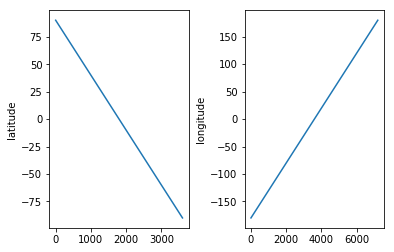

In [155]:
plt.figure()
plt.subplot(121)
plt.plot(lat.data)
plt.ylabel("latitude")
plt.subplot(122)
plt.plot(lon.data)
plt.ylabel("longitude")
plt.subplots_adjust(wspace=0.4)
plt.show

We can confirm very different grids from netcdf and era-interim, as longitude goes from -180:180 rather than 0:360. We need to make sure that this is accounted for and that these data get a special different mask for the SW US than other types of grids. 


In [156]:
X, Y = np.meshgrid(lon.data, lat.data)

In [175]:
print(lat_range)
print(lon_range)

(30.0, 42)
(-115.0, -102)


In [176]:
X_mask = (X >= lon_range[0]) & (X <= lon_range[1]) 
print(np.unique(X_mask))

[False  True]


In [177]:
Y_mask = (Y >= lat_range[0]) & (Y <= lat_range[1]) 
print(np.unique(X_mask))

[False  True]


In [178]:
spatial_mask = Y_mask & X_mask

In [179]:
spatial_mask.shape

(3600, 7200)

In [180]:
np.sum(spatial_mask)

62400

In [181]:
print(X[spatial_mask].max())
print(X[spatial_mask].min())
print(Y[spatial_mask].max())
print(Y[spatial_mask].min())

-102.04524
-114.99603
41.998753
30.048935


In [93]:
# plot as spatial mask to save time. 

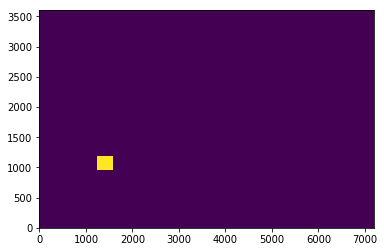

In [69]:
plt.pcolor(spatial_mask)

In [182]:
np.sum(spatial_mask==False)

25857600

In [183]:
(spatial_mask.shape[0] * spatial_mask.shape[1]) - np.sum(spatial_mask==False)

62400

In [184]:
sw_data = ma.masked_where(spatial_mask==False, Z)

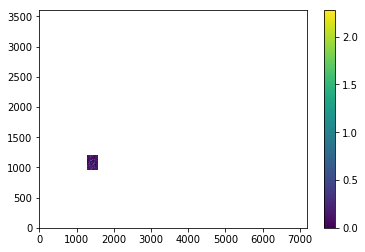

In [185]:
plt.pcolor(sw_data)
plt.colorbar()

In [186]:
# These do the same thing with masked arrays
print(np.mean(sw_data))
print(ma.mean(sw_data))

0.15125332563411614
0.15125332563411614


In [187]:
nc.close()

### Now that these data are fully understood and the mask required is created
- Make monthly mean time series of data in this region. 
- plot these monthly mean time series. 

In [188]:
not_SW = spatial_mask==False # i.e. true outside SW, values we do not want, will be masked

In [189]:
# lists to store results
monthly_mean_value = []
monthly_month_value = []
monthly_year_value = []
# TODO: keep track of how many non-masked values there are? 

# For a given year of monthly data 
for year in np.arange(1983, 2016) : 
    
    year_file = 'monmeans_' + str(year) + '.nc'
    print("Working on loading %s " %year_file)

    # Make file connection 
    nc = Dataset(os.path.join(lai_monthly_dir, year_file), "r")
    lai = nc.variables["LAI"][:] # ma.masked_array

    # Make sure there are 12 months in the yearly data 
    if lai.shape[0] != 12 :
        raise ValueError("There should be 12 months in %s" %year_file)

    for i in range(12) : 
        # not_SW is False over the SW, True elsehwere so this mask 
        # masks all non SW areas. 
        lai_masked = ma.masked_where(not_SW, lai[i,:,:])

        # Now take the mean of the mostly masked grid. 
        monthly_mean_value.append(np.mean(lai_masked))
        monthly_year_value.append(year)
        monthly_month_value.append(i+1) # Want Jan to be represented by a 1. 
        
    nc.close()

Working on loading monmeans_1983.nc 
Working on loading monmeans_1984.nc 
Working on loading monmeans_1985.nc 
Working on loading monmeans_1986.nc 
Working on loading monmeans_1987.nc 
Working on loading monmeans_1988.nc 
Working on loading monmeans_1989.nc 
Working on loading monmeans_1990.nc 
Working on loading monmeans_1991.nc 
Working on loading monmeans_1992.nc 
Working on loading monmeans_1993.nc 
Working on loading monmeans_1994.nc 
Working on loading monmeans_1995.nc 
Working on loading monmeans_1996.nc 
Working on loading monmeans_1997.nc 
Working on loading monmeans_1998.nc 
Working on loading monmeans_1999.nc 
Working on loading monmeans_2000.nc 
Working on loading monmeans_2001.nc 
Working on loading monmeans_2002.nc 
Working on loading monmeans_2003.nc 
Working on loading monmeans_2004.nc 
Working on loading monmeans_2005.nc 
Working on loading monmeans_2006.nc 
Working on loading monmeans_2007.nc 
Working on loading monmeans_2008.nc 
Working on loading monmeans_2009.nc 
W

In [190]:
monthly_mean_value  = np.array(monthly_mean_value)
monthly_year_value  = np.array(monthly_year_value)
monthly_month_value = np.array(monthly_month_value)

In [191]:
sw_mean_LAI = pd.DataFrame({'year':monthly_year_value, 'month':monthly_month_value, 'LAI':monthly_mean_value})
sw_mean_LAI.iloc[:5,:]

,year,month,LAI
0,1983,1,0.179576
1,1983,2,0.188919
2,1983,3,0.276118
3,1983,4,0.342592
4,1983,5,0.418552


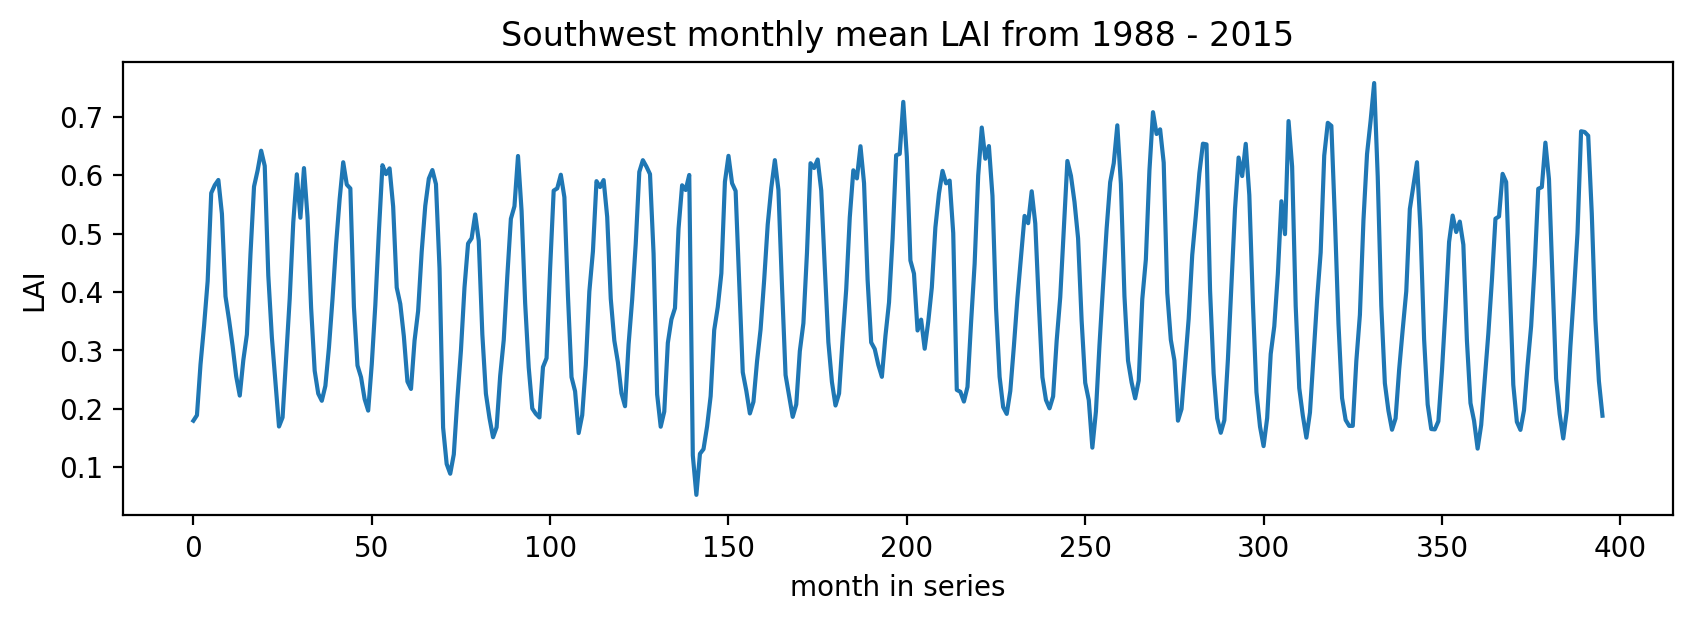

In [192]:
plt.figure(figsize=(10,3), dpi=200)
plt.plot(sw_mean_LAI.LAI)
plt.ylabel("LAI")
plt.xlabel("month in series")
plt.title("Southwest monthly mean LAI from 1988 - 2015")
plt.show()

In [193]:
lai_seasonal_average = sw_mean_LAI.groupby(["month"]).mean().copy()
lai_seasonal_average

,year,LAI
month,,
1,1999,0.187874
2,1999,0.207950
3,1999,0.296710
4,1999,0.370647
5,1999,0.478942
6,1999,0.586015
7,1999,0.593381
8,1999,0.626496
9,1999,0.551315


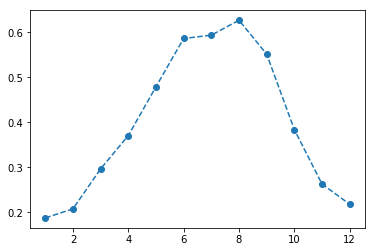

In [194]:
plt.plot(lai_seasonal_average.LAI, "--o")

In [195]:
# Save all the relavent information as a Pandas dataframe, then write it to a .csv 
sw_mean_LAI.to_csv(os.path.join("..","Data","LAI", "SW_monthly_mean_LAI.csv"))
lai_seasonal_average.to_csv(os.path.join("..","Data","LAI", "SW_monthly_mean_LAI_climatology.csv"))

#### Now save the SW mask as a netcdf file that can be regridded using CDO 
- This will give us a masking grid that can be applied to CMIP5 nc data and match the sattelite LAI grids just created
- use of cdo ensures maintaining common grid propoerty structures of the desired mask


In [196]:
# recal spatial_mask True for the region of interest 
M = np.array(spatial_mask, dtype=int)

In [197]:
print(np.sum(M))
print(M.shape)

62400
(3600, 7200)


In [198]:
print(len(lat))
print(len(lon))

3600
7200


In [199]:
# Write this land mask as a netcdf file 
outputFile = os.path.join("..","Data","LandCover", "SW_region_mask.nc")

ncFile = Dataset(outputFile, 'w', format='NETCDF4')
ncFile.description = 'SW mask on the original LAI grid'
ncFile.location = 'Global'
ncFile.createDimension('latitude', len(lat) )
ncFile.createDimension('longitude', len(lon) )

# create lat variable
latitude_ = ncFile.createVariable('latitude', 'f4', ('latitude',))
latitude_.units = 'degrees_north'
latitude_.axis = "Y"

# create longitude variable
longitude_ = ncFile.createVariable('longitude', 'f4', ('longitude',))
longitude_.units = "degrees_east"
longitude_.long_name = "longitude"
longitude_.axis = "X"

VAR_ = ncFile.createVariable("SW_Mask", 'f4',('latitude','longitude'))
VAR_.units = "1=in_region, 0=outside_region"
VAR_[:]    = M

latitude_[:]  = np.array(lat)
longitude_[:] = np.array(lon)

ncFile.close()

Make the common grid version using CDO, remember, that has to be done outside juypter lab.
Write now this is done in the LandCover data directory using the following command
```shell
$ cdo remapbil,COMMON_GRID.txt SW_region_mask.nc SW_region_mask_common_grid.nc
```

In [203]:
nc = Dataset(os.path.join("..","Data","LandCover", "SW_region_mask_common_grid.nc"))
SW_region_common_grid = nc.variables["SW_Mask"][:]
nc.close()

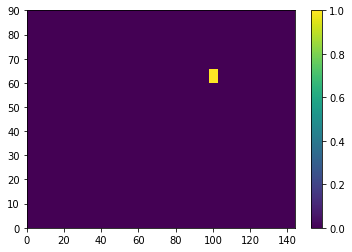

In [205]:
plt.pcolor(SW_region_common_grid)
plt.colorbar()

And here is what windspeed looks like for netcdf CMIP5 common grid

In [206]:
nc = Dataset(os.path.join("..","Data","CMIP5", "r1i1p1_rcp_COMMON_GRID", 'hurs_Amon_ACCESS1-0_rcp45_r1i1p1_198301-210012.nc'))
hurs = nc.variables["hurs"][:]
nc.close()

In [208]:
hurs.shape

(1416, 90, 144)

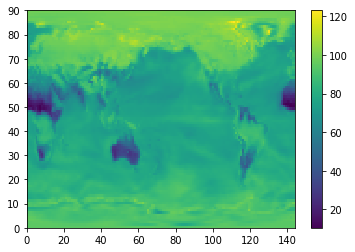

In [209]:
plt.pcolor(hurs[0,:,:])
plt.colorbar()